In [1]:
import pandas as pd

import numpy as np

import math

In [2]:
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import roc_auc_score,roc_curve


## Multivariate Filter
from sklearn.feature_selection import mutual_info_classif


from sklearn.feature_selection import RFE


## Wrapper Filter 
from sklearn.feature_selection import SequentialFeatureSelector


import matplotlib.pyplot as plt



In [4]:
df=pd.read_csv('cleaned.csv')

## remove rows containing null values

df=df.replace(np.nan,None)
df=df[~df.isnull().all(1)]


x=df.iloc[:,:-1]

x_cols=x.columns

## for x select all columns except the last
X=df.iloc[:,:-1].to_numpy()






## for y select the last
y_df=df.iloc[:,-1]
y=df.iloc[:,-1].to_numpy()



In [4]:
df.head()

,finished_first_q1,finished_first_q2,dif_seconds_quali_first_second,dif_seconds_quali_second_third,dif_seconds_quali_third_fourth,dif_seconds_qualif_fourth_fifth,isAmericas,isAustralia,isEurope,is_reigning_constructor_champion,is_reigning_driver_champion,driverAge,hadRain,avg_temp,avg_humidity,avg_pressure,avg_wind_speed,constructorPositionPreRace,driverPositionPreRace,finishedFirst
0,0,1,0.141,0.366,0.609,0.024,0,0,0,0.0,0.0,8290,0,87.916667,35.291667,1012.550000,7.833333,1.0,1.0,0
1,1,1,0.116,0.076,0.564,0.162,0,1,0,0.0,0.0,8304,0,75.400000,49.168333,1009.616667,13.166667,4.0,4.0,0
2,0,0,1.346,0.116,0.125,0.087,0,0,0,0.0,0.0,12273,0,88.100000,67.860000,1007.600000,8.783333,5.0,10.0,0
3,0,0,0.250,0.105,0.010,0.056,0,0,0,0.0,0.0,8325,0,67.350000,73.275000,1016.266667,15.633333,3.0,3.0,0
4,1,1,0.106,0.728,0.108,0.054,0,0,1,0.0,0.0,12308,0,66.350000,61.245000,1006.733333,8.600000,3.0,8.0,1


In [5]:
## Check dataset to see if it's imabalanced

df['finishedFirst'].value_counts()

## Dataset is nearly balanced 


finishedFirst
1    151
0    142
Name: count, dtype: int64

In [6]:

## due to differences in data scale we will apply standard scaling.





## Scale only the continuous/d variables as the categorical variables do not need this

X_binary=X[:,[0,1,6,7,8,9,10,12]]

X_numeric=X[:,[2,3,4,5,11,13,14,15,16,17,18]]

scaler=StandardScaler()

scaler.fit(X_numeric)

X_discrete=X[:,[0,1,6,7,8,9,10,12,17,18]] 

X_continuous_scaled=scaler.transform(X_numeric)

X_binary_cols=x.columns[[0,1,6,7,8,9,10,12]].tolist()
X_numeric_cols=x.columns[[2,3,4,5,11,13,14,15,16,17,18]].tolist()



X_scaled=np.concatenate([X_numeric,X_binary],axis=1)


data_out=pd.DataFrame(X_scaled,columns=(X_numeric_cols+X_binary_cols))
data_out['finishedFirst']=y



def toStr(val):
    if val==1:
        return 'y'
    if val==0:
        return 'n'

data_out['finishedFirst']=data_out['finishedFirst'].apply(lambda x: toStr(x))




data_out.to_csv('dataset_scaled.csv',index=False)





from sklearn.model_selection import train_test_split


subset=df.sample(frac=.8,axis=0)

subset=subset.reset_index(drop=True)


numeric_features=subset.iloc[:,0:9] 

categorical_features=subset.iloc[:,9:-1]

target=subset.iloc[:,-1]

## Apply univariate filtering 

## we have 19 total features, 9 are continuous, 10 are discrete (binary)

## we will choose 9 features, 5 from categorical and 4 from continuous



### Univariate Filter
from sklearn.feature_selection import SelectKBest, f_regression, chi2 # f_regression for continuous, chi2 for 



chi2_selector = SelectKBest(chi2, k='all')  # Select all features initially to get their scores
chi2_selector.fit(categorical_features, target)
chi2_scores = chi2_selector.scores_

anova_selector = SelectKBest(f_regression, k='all')  # Using F-test for continuous features
anova_selector.fit(numeric_features, target)
anova_scores = anova_selector.scores_


all_feature_scores = pd.DataFrame({
    'Feature': np.concatenate([categorical_features.columns, numeric_features.columns]),
    'Score': np.concatenate([chi2_scores, anova_scores])
    })

all_feature_scores['Category']=['Categorical','Categorical','Categorical','Categorical',
                                'Categorical','Categorical','Categorical','Categorical',
                                'Categorical','Categorical','Numeric','Numeric',
                                'Numeric','Numeric','Numeric','Numeric','Numeric',
                                'Numeric','Numeric']


## We will select all features and later apply the 

k = 19
top_k_features = all_feature_scores.nlargest(k, 'Score')



X_categorical_features=all_feature_scores[all_feature_scores.Category == 'Categorical'].nlargest(5, 'Score')['Feature']
X_numeric_features=all_feature_scores[all_feature_scores.Category == 'Numeric'].nlargest(4, 'Score')['Feature']


top_x_cols=[]


for a_col in X_categorical_features.tolist():
    top_x_cols.append(a_col)

for a_col in X_numeric_features.tolist():
    top_x_cols.append(a_col)


X_kbest=df.loc[:,top_x_cols].to_numpy()



scalerKBest=StandardScaler()

scalerKBest.fit(X_kbest)


X_kbest_scaled=scalerKBest.transform(X_kbest)


# Multivariate Filter (Correlation feature selection wrapper in Weka

## output returned just 4 columns 8,10,12,17 so we select those

X_corr_fs_scaled=X_scaled[:,[8,10,12,17]]



## initialize a df to save our model results
model_results=pd.DataFrame()


X_lib={'all_features':X_scaled,'univariate_filter':X_kbest_scaled,'multivariate':X_corr_fs_scaled,'wrapper':X_scaled}



print(len(X_scaled))

293


variables method: all_features
Grid Search
Cross Validation
variables method: univariate_filter
Grid Search
Cross Validation
variables method: multivariate
Grid Search
Cross Validation
variables method: wrapper
Grid Search
Cross Validation


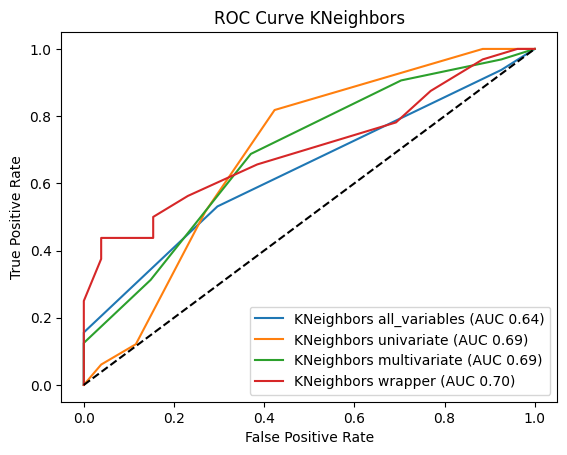

In [7]:
### K-Nearest Neighbors 
from sklearn.metrics import confusion_matrix







from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score




model=KNeighborsClassifier()

aucs_=[]
tprs_=[]
fprs_=[]


for a_set in X_lib.keys():

  


    X_vars=X_lib[a_set]

    variables=a_set

    print('variables method: '+variables)

    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)
 

    if variables=='wrapper':
        
    
        # Apply Forward Selection with 9 variables
        selector = SequentialFeatureSelector(estimator=model, n_features_to_select=9, direction='forward')

        selector.fit(X_train, y_train)

        # Get the boolean mask of the selected features
        selected_mask = selector.get_support()

        # Get the indices of the selected features
        selected_indices = [i for i, x in enumerate(selected_mask) if x]


        X_vars=X_vars[:,selected_indices]

        # print(np.shape(X_vars))
    
   
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)


     ## use gridsearch 
    
    grid ={"n_neighbors":np.arange(1,20)}
    model= KNeighborsClassifier()


   
    ## Implement Grid Search
    from sklearn.model_selection import GridSearchCV


    gs_cv=GridSearchCV(model,grid,cv=10) #GridSearchCV
    print('Grid Search')
    gs_cv.fit(X_train,y_train)
    # print("tuned hyperparameter K:",gs_cv.best_params_)


    ## use KFold CV as well using the GridSearch Parameters
    from sklearn.model_selection import KFold
    scores=[]
    precisions=[]
    recalls=[]
    f1s=[]

    tps=[]
    tns=[]
    fps=[]
    fns=[]

    aucs=[]
    tprs=[]
    fprs=[]

    kFold=KFold(n_splits=5,shuffle=False)

    # use best gridsearch parameter
   
    counter=1
    print('Cross Validation')
    for train_index,test_index in kFold.split(X_vars):
        # print('Fold #'+str(counter))
        
        model=KNeighborsClassifier(n_neighbors=gs_cv.best_params_['n_neighbors'])

        X_train, X_test, y_train, y_test = X_vars[train_index], X_vars[test_index], y[train_index], y[test_index]
    
        model.fit(X_train, y_train)
        
        scores.append(model.score(X_test, y_test))

        preds=model.predict(X_test)

        C=confusion_matrix(y_test, preds)

        # print(C)


        tp=C[0,0]
        tn=C[1,1]

        fp=C[0,1]
        fn=C[1,0]

        tps.append(tp)
        tns.append(tn)
        
        fps.append(fp)
        fns.append(fn)

        precision=tp/(tp+fp)

        precisions.append(precision)

        recall=tp/(tp+fn)

        recalls.append(recall)



        f1=2*tp/((2*tp)+fp+fn)

        f1s.append(f1)

        y_prob=model.predict_proba(X_test)

        y_prob=y_prob[:,-1]

        auc=roc_auc_score(y_test,y_prob).mean()

        aucs.append(auc) 

        
        fpr, tpr, _ = roc_curve(y_test, y_prob)

        fprs.append(fpr)
        tprs.append(tpr)

    

        counter+=1



    max_auc_idx=aucs.index(max(aucs))

    fprs_.append(fprs[max_auc_idx])
    tprs_.append(tprs[max_auc_idx])
    aucs_.append(aucs[max_auc_idx])







    # print(precisions)
    # print(recalls)
    # print(f1s)
    # print(tps)

    kfold_mean_precision=np.mean(precisions)
    kfold_mean_recall=np.mean(recalls)
    kfold_mean_f1=np.mean(f1s)

    kfold_min_precision=np.min(precisions)
    kfold_min_recall=np.max(recalls)
    kfold_min_f1=np.min(f1s)

    kfold_max_precision=np.max(precisions)
    kfold_max_recall=np.max(recalls)
    kfold_max_f1=np.max(f1s)

    
    kfold_mean_tps=np.mean(tps)
    kfold_mean_tns=np.mean(tns)
    kfold_mean_fps=np.mean(fps)
    kfold_mean_fns=np.mean(fns)


    kfold_mean_accuracy=np.mean(scores)
    kfold_min_accuracy=np.min(scores)
    kfold_max_accuracy=np.max(scores)

    kfold_min_auc=np.min(aucs)
    kfold_mean_auc=np.mean(aucs)
    kfold_max_auc=np.max(aucs)



    temp_results=pd.DataFrame({'algorithm':['KMeans'],
                               'variable_method':[variables],
                               'hyper_parameters':[gs_cv.best_params_],
                               'cv_min_accuracy':[kfold_min_accuracy],
                               'cv_max_accuracy':[kfold_min_accuracy],
                               'cv_mean_accuracy':[kfold_min_accuracy],
                               'cv_min_precision':[kfold_min_precision],
                               'cv_max_precision':[kfold_max_precision],
                               'cv_mean_precision':[kfold_mean_precision],
                               'cv_min_f1':[kfold_min_f1],
                               'cv_max_f1':[kfold_max_f1],
                               'cv_mean_f1':[kfold_mean_f1],
                               'cv_mean_tps':[kfold_mean_tps],
                               'cv_mean_tns':[kfold_mean_tns],
                               'cv_mean_fps':[kfold_mean_fps],
                               'cv_mean_fns':[kfold_mean_fns],
                               'cv_mean_auc':[kfold_mean_auc],
                               'cv_min_auc':[kfold_min_auc],
                               'cv_max_auc':[kfold_max_auc]
                               })
    model_results=pd.concat([model_results,temp_results])


## Plot AUC best with each method
plt.figure()



methods=['all_variables','univariate','multivariate','wrapper']

for idx in range(0,len(X_lib.keys())):
    cur_method=methods[idx]
    plt.plot(fprs_[idx], tprs_[idx], label=f"KNeighbors "+cur_method+f" (AUC {aucs_[idx]:.2f})")
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve KNeighbors")
plt.legend(loc="best")
# plt.show()

plt.savefig('AUC_comparison_KNeighbors.png')


In [12]:
print(roc_auc_score(y_test,y_prob))

0.6784855769230771


In [ ]:
### SVC
from sklearn.metrics import confusion_matrix





from sklearn.model_selection import cross_val_score

from sklearn import svm




model=svm.SVC()

aucs_=[]
tprs_=[]
fprs_=[]



for a_set in X_lib.keys():

    X_vars=X_lib[a_set]

    variables=a_set

    print('variables method: '+variables)


    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)


    if variables=='wrapper':
        
    
        # Apply Forward Selection with 8 variables
        selector = SequentialFeatureSelector(estimator=model, n_features_to_select=9, direction='forward')

        selector.fit(X_train, y_train)

        # Get the boolean mask of the selected features
        selected_mask = selector.get_support()

        # Get the indices of the selected features
        selected_indices = [i for i, x in enumerate(selected_mask) if x]


        X_vars=X_vars[:,selected_indices]

        # print(np.shape(X_vars))
    
   
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)


     ## use gridsearch 
    
    model= svm.SVC()

    # grid={'kernel':['linear'],
    #       'C':[0.1],
    #       'gamma':['scale']}

    grid ={"kernel":['linear', 'poly', 'rbf', 'sigmoid', ],
        'C': [0.1, .5, 1, 2, 3, 4, 5, 6, 7 ,8, 9, 10, 100],
        'gamma': ['scale', 'auto']}
   
    ## Implement Grid Search
    from sklearn.model_selection import GridSearchCV


    gs_cv=GridSearchCV(model,grid,cv=10) #GridSearchCV
    print('Grid Search')
    gs_cv.fit(X_train,y_train)
    # print("tuned hyperparameter K:",gs_cv.best_params_)


    ## use KFold CV as well using the GridSearch Parameters
    from sklearn.model_selection import KFold
    scores=[]
    precisions=[]
    recalls=[]
    f1s=[]

    tps=[]
    tns=[]
    fps=[]
    fns=[]
    aucs=[]

    fprs=[]
    tprs=[]
    

    kFold=KFold(n_splits=5,shuffle=False)

    # use best gridsearch parameter
   
    counter=1
    print('Cross Validation')
    for train_index,test_index in kFold.split(X_vars):
        # print('Fold #'+str(counter))
        
        model=svm.SVC(probability=True,C=gs_cv.best_params_['C'],kernel=gs_cv.best_params_['kernel'],gamma=gs_cv.best_params_['gamma'])

        X_train, X_test, y_train, y_test = X_vars[train_index], X_vars[test_index], y[train_index], y[test_index]
    
        model.fit(X_train, y_train)
        
        scores.append(model.score(X_test, y_test))

        preds=model.predict(X_test)

        C=confusion_matrix(y_test, preds)

        # print(C)


        tp=C[0,0]
        tn=C[1,1]

        fp=C[0,1]
        fn=C[1,0]

        tps.append(tp)
        tns.append(tn)
        
        fps.append(fp)
        fns.append(fn)

        precision=tp/(tp+fp)

        precisions.append(precision)

        recall=tp/(tp+fn)

        recalls.append(recall)



        f1=2*tp/((2*tp)+fp+fn)

        f1s.append(f1)

        y_prob=model.predict_proba(X_test)

        y_prob=y_prob[:,-1]

        auc=roc_auc_score(y_test,y_prob).mean()

        aucs.append(auc) 

        fpr, tpr, _ = roc_curve(y_test, y_prob)

        fprs.append(fpr)
        tprs.append(tpr)

        

        counter+=1


    max_auc_idx=aucs.index(max(aucs))

    fprs_.append(fprs[max_auc_idx])
    tprs_.append(tprs[max_auc_idx])
    aucs_.append(aucs[max_auc_idx])

    # print(precisions)
    # print(recalls)
    # print(f1s)
    # print(tps)

    kfold_mean_precision=np.mean(precisions)
    kfold_mean_recall=np.mean(recalls)
    kfold_mean_f1=np.mean(f1s)

    kfold_min_precision=np.min(precisions)
    kfold_min_recall=np.max(recalls)
    kfold_min_f1=np.min(f1s)

    kfold_max_precision=np.max(precisions)
    kfold_max_recall=np.max(recalls)
    kfold_max_f1=np.max(f1s)

    
    kfold_mean_tps=np.mean(tps)
    kfold_mean_tns=np.mean(tns)
    kfold_mean_fps=np.mean(fps)
    kfold_mean_fns=np.mean(fns)


    kfold_mean_accuracy=np.mean(scores)
    kfold_min_accuracy=np.min(scores)
    kfold_max_accuracy=np.max(scores)

    kfold_min_auc=np.min(aucs)
    kfold_mean_auc=np.mean(aucs)
    kfold_max_auc=np.max(aucs)



    temp_results=pd.DataFrame({'algorithm':['SVC'],
                               'variable_method':[variables],
                               'hyper_parameters':[gs_cv.best_params_],
                               'cv_min_accuracy':[kfold_min_accuracy],
                               'cv_max_accuracy':[kfold_min_accuracy],
                               'cv_mean_accuracy':[kfold_min_accuracy],
                               'cv_min_precision':[kfold_min_precision],
                               'cv_max_precision':[kfold_max_precision],
                               'cv_mean_precision':[kfold_mean_precision],
                               'cv_min_f1':[kfold_min_f1],
                               'cv_max_f1':[kfold_max_f1],
                               'cv_mean_f1':[kfold_mean_f1],
                               'cv_mean_tps':[kfold_mean_tps],
                               'cv_mean_tns':[kfold_mean_tns],
                               'cv_mean_fps':[kfold_mean_fps],
                               'cv_mean_fns':[kfold_mean_fns],
                               'cv_mean_auc':[kfold_mean_auc],
                               'cv_min_auc':[kfold_min_auc],
                               'cv_max_auc':[kfold_max_auc]
                               })
    model_results=pd.concat([model_results,temp_results])



## Plot AUC best with each method
plt.figure()



methods=['all_variables','univariate','multivariate','wrapper']

for idx in range(0,len(X_lib.keys())):
    cur_method=methods[idx]
    plt.plot(fprs_[idx], tprs_[idx], label=f"SVC "+cur_method+f" (AUC {aucs_[idx]:.2f})")
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve SVC")
plt.legend(loc="best")
# plt.show()


plt.savefig('AUC_comparison_SVC.png')




variables method: all_features
Grid Search


variables method: all_features
Grid Search


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
5880 fits failed out of a total of 52920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5880 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\

Cross Validation
variables method: univariate_filter
Grid Search


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
5880 fits failed out of a total of 52920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5880 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\

Cross Validation
variables method: multivariate
Grid Search


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
5880 fits failed out of a total of 52920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5880 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\

Cross Validation
variables method: wrapper
Grid Search


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
5880 fits failed out of a total of 52920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5880 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\

Cross Validation


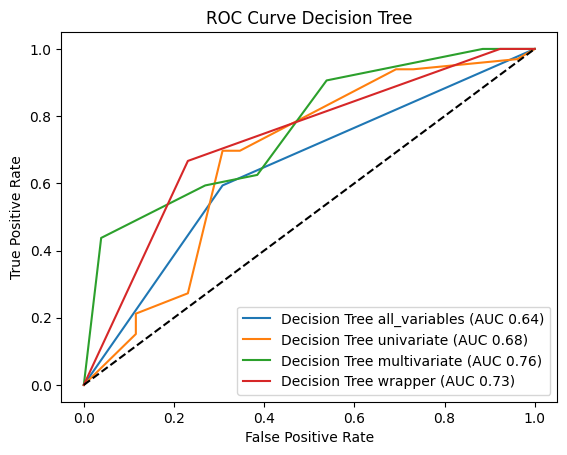

In [97]:
### Decision Tree
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier





from sklearn.model_selection import cross_val_score

aucs_=[]
tprs_=[]
fprs_=[]

model=DecisionTreeClassifier()

for a_set in X_lib.keys():

    X_vars=X_lib[a_set]

    variables=a_set

    print('variables method: '+variables)

    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)

    

    if variables=='wrapper':
        
    
        # Apply Forward Selection with 8 variables
        selector = SequentialFeatureSelector(estimator=model, n_features_to_select=9, direction='forward')

        selector.fit(X_train, y_train)

        # Get the boolean mask of the selected features
        selected_mask = selector.get_support()

        # Get the indices of the selected features
        selected_indices = [i for i, x in enumerate(selected_mask) if x]


        X_vars=X_vars[:,selected_indices]

        # print(np.shape(X_vars))
    
   
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)


    ## use gridsearch 
    
    model= DecisionTreeClassifier()

    grid ={"criterion":['gini', 'entropy', 'log_loss' ],
            'max_features': np.arange(1,15),
            'max_depth': np.arange(1,15),
            'min_samples_split':np.arange(1,10)
            }
   
    ## Implement Grid Search
    from sklearn.model_selection import GridSearchCV


    gs_cv=GridSearchCV(model,grid,cv=10) #GridSearchCV
    print('Grid Search')
    gs_cv.fit(X_train,y_train)
    # print("tuned hyperparameter K:",gs_cv.best_params_)


    ## use KFold CV as well using the GridSearch Parameters
    from sklearn.model_selection import KFold
    scores=[]
    precisions=[]
    recalls=[]
    f1s=[]

    tps=[]
    tns=[]
    fps=[]
    fns=[]
    aucs=[]

    fprs=[]
    tprs=[]

    kFold=KFold(n_splits=5,shuffle=False)

    # use best gridsearch parameter
   
    counter=1
    print('Cross Validation')
    for train_index,test_index in kFold.split(X_vars):
        # print('Fold #'+str(counter))
        
        model=DecisionTreeClassifier(criterion=gs_cv.best_params_['criterion'],
                                     max_features=gs_cv.best_params_['max_features'],
                                     max_depth=gs_cv.best_params_['max_depth'],
                                     min_samples_split=gs_cv.best_params_['min_samples_split']
                                     )

        X_train, X_test, y_train, y_test = X_vars[train_index], X_vars[test_index], y[train_index], y[test_index]
    
        model.fit(X_train, y_train)
        
        scores.append(model.score(X_test, y_test))

        preds=model.predict(X_test)

        C=confusion_matrix(y_test, preds)

        # print(C)


        tp=C[0,0]
        tn=C[1,1]

        fp=C[0,1]
        fn=C[1,0]

        tps.append(tp)
        tns.append(tn)
        
        fps.append(fp)
        fns.append(fn)

        precision=tp/(tp+fp)

        precisions.append(precision)

        recall=tp/(tp+fn)

        recalls.append(recall)



        f1=2*tp/((2*tp)+fp+fn)

        f1s.append(f1)

        y_prob=model.predict_proba(X_test)

        y_prob=y_prob[:,-1]

        auc=roc_auc_score(y_test,y_prob).mean()

        aucs.append(auc) 
        
        fpr, tpr, _ = roc_curve(y_test, y_prob)

        fprs.append(fpr)
        tprs.append(tpr)

  

        counter+=1


    max_auc_idx=aucs.index(max(aucs))

    fprs_.append(fprs[max_auc_idx])
    tprs_.append(tprs[max_auc_idx])
    aucs_.append(aucs[max_auc_idx])



    # print(precisions)
    # print(recalls)
    # print(f1s)
    # print(tps)

    kfold_mean_precision=np.mean(precisions)
    kfold_mean_recall=np.mean(recalls)
    kfold_mean_f1=np.mean(f1s)

    kfold_min_precision=np.min(precisions)
    kfold_min_recall=np.max(recalls)
    kfold_min_f1=np.min(f1s)

    kfold_max_precision=np.max(precisions)
    kfold_max_recall=np.max(recalls)
    kfold_max_f1=np.max(f1s)

    
    kfold_mean_tps=np.mean(tps)
    kfold_mean_tns=np.mean(tns)
    kfold_mean_fps=np.mean(fps)
    kfold_mean_fns=np.mean(fns)


    kfold_mean_accuracy=np.mean(scores)
    kfold_min_accuracy=np.min(scores)
    kfold_max_accuracy=np.max(scores)

    kfold_min_auc=np.min(aucs)
    kfold_mean_auc=np.mean(aucs)
    kfold_max_auc=np.max(aucs)



    temp_results=pd.DataFrame({'algorithm':['KMeans'],
                               'variable_method':[variables],
                               'hyper_parameters':[gs_cv.best_params_],
                               'cv_min_accuracy':[kfold_min_accuracy],
                               'cv_max_accuracy':[kfold_min_accuracy],
                               'cv_mean_accuracy':[kfold_min_accuracy],
                               'cv_min_precision':[kfold_min_precision],
                               'cv_max_precision':[kfold_max_precision],
                               'cv_mean_precision':[kfold_mean_precision],
                               'cv_min_f1':[kfold_min_f1],
                               'cv_max_f1':[kfold_max_f1],
                               'cv_mean_f1':[kfold_mean_f1],
                               'cv_mean_tps':[kfold_mean_tps],
                               'cv_mean_tns':[kfold_mean_tns],
                               'cv_mean_fps':[kfold_mean_fps],
                               'cv_mean_fns':[kfold_mean_fns],
                               'cv_mean_auc':[kfold_mean_auc],
                               'cv_min_auc':[kfold_min_auc],
                               'cv_max_auc':[kfold_max_auc]
                               })
    model_results=pd.concat([model_results,temp_results])


## Plot AUC best with each method
plt.figure()



methods=['all_variables','univariate','multivariate','wrapper']

for idx in range(0,len(X_lib.keys())):
    cur_method=methods[idx]
    plt.plot(fprs_[idx], tprs_[idx], label=f"Decision Tree "+cur_method+f" (AUC {aucs_[idx]:.2f})")
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Decision Tree")
plt.legend(loc="best")
# plt.show()


plt.savefig('AUC_comparison_Decision_Tree.png')




variables method: all_features
<class 'scikeras.wrappers.KerasClassifier'>
Grid Search


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Cross Validation
Fold #1
<class 'scikeras.wrappers.KerasClassifier'>
Epoch 1/10


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5748 - loss: 0.6773  
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6130 - loss: 0.6615 
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6313 - loss: 0.6390 
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6734 - loss: 0.6123 
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6819 - loss: 0.6031 
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7244 - loss: 0.5821 
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6721 - loss: 0.5921 
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6902 - loss: 0.5788 
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7171 - loss: 0.5593 
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7585 - loss: 0.5473 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Fold #2
<class 'scikeras.wrappers.KerasClassifier'>
Epoch 1/10


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4830 - loss: 0.7054  
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5950 - loss: 0.6574 
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6355 - loss: 0.6502 
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6543 - loss: 0.6368 
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7114 - loss: 0.6174 
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6927 - loss: 0.6123 
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7361 - loss: 0.6041 
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7114 - loss: 0.5934 
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6862 - loss: 0.6019 
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7301 - loss: 0.5881 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Fold #3
<class 'scikeras.wrappers.KerasClassifier'>
Epoch 1/10


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4959 - loss: 0.6945  
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6168 - loss: 0.6523 
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6864 - loss: 0.6313 
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6894 - loss: 0.6249 
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6688 - loss: 0.6240 
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6430 - loss: 0.6327 
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7006 - loss: 0.5981 
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6863 - loss: 0.5924 
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6969 - loss: 0.5888 
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7220 - loss: 0.5732 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Fold #4
<class 'scikeras.wrappers.KerasClassifier'>
Epoch 1/10


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4863 - loss: 0.7288  
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6074 - loss: 0.6633 
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5963 - loss: 0.6643 
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6116 - loss: 0.6456 
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6586 - loss: 0.6206 
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6067 - loss: 0.6440 
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6462 - loss: 0.6130 
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7083 - loss: 0.5920 
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6321 - loss: 0.6175 
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6929 - loss: 0.5828 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Fold #5
<class 'scikeras.wrappers.KerasClassifier'>
Epoch 1/10


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4574 - loss: 0.7137  
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6275 - loss: 0.6681 
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6157 - loss: 0.6582 
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6580 - loss: 0.6563 
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6494 - loss: 0.6557 
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6957 - loss: 0.6320 
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6853 - loss: 0.6284 
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7224 - loss: 0.6115  
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6928 - loss: 0.6170 
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7328 - loss: 0.5962 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
variables method: univariate_filter
<class 'scikeras.wrappers.Ke

c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Cross Validation
Fold #1
<class 'scikeras.wrappers.KerasClassifier'>
Epoch 1/10


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5766 - loss: 0.6761  
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6520 - loss: 0.6457 
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6233 - loss: 0.6499 
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6569 - loss: 0.6339
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6572 - loss: 0.6354 
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6912 - loss: 0.6189 
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6555 - loss: 0.6194 
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6912 - loss: 0.6169 
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6775 - loss: 0.6082 
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7067 - loss: 0.5898 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold #2
<class 'scikeras.wrappers.KerasClassifier'>
Epoch 1/10


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5932 - loss: 0.6715  
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6941 - loss: 0.6345 
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6654 - loss: 0.6338 
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6401 - loss: 0.6468 
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6747 - loss: 0.6064 
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6950 - loss: 0.6015 
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6625 - loss: 0.6062 
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6874 - loss: 0.5942 
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7037 - loss: 0.6051 
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6569 - loss: 0.6248 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Fold #3
<class 'scikeras.wrappers.KerasClassifier'>
Epoch 1/10


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4851 - loss: 0.7084  
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5589 - loss: 0.6783 
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6189 - loss: 0.6653 
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6096 - loss: 0.6642 
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6380 - loss: 0.6520 
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6476 - loss: 0.6448 
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6517 - loss: 0.6374 
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6476 - loss: 0.6397 
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6475 - loss: 0.6270 
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6474 - loss: 0.6155 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Fold #4
<class 'scikeras.wrappers.KerasClassifier'>
Epoch 1/10


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5924 - loss: 0.6922  
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6219 - loss: 0.6628 
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6314 - loss: 0.6454 
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6618 - loss: 0.6340 
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6952 - loss: 0.6208 
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6950 - loss: 0.6086 
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6108 - loss: 0.6377 
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6583 - loss: 0.6197 
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6804 - loss: 0.6003 
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6916 - loss: 0.5955 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Fold #5
<class 'scikeras.wrappers.KerasClassifier'>
Epoch 1/10


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5059 - loss: 0.7009  
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6106 - loss: 0.6733 
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5770 - loss: 0.6744 
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5846 - loss: 0.6692 
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6216 - loss: 0.6464 
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6324 - loss: 0.6473 
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6076 - loss: 0.6651 
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6502 - loss: 0.6423 
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6283 - loss: 0.6223 
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6532 - loss: 0.6377 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
variables method: multivariate
<class 'scikeras.wrappers.KerasCla

c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Cross Validation
Fold #1
<class 'scikeras.wrappers.KerasClassifier'>
Epoch 1/100


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5507 - loss: 0.6746
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6233 - loss: 0.6669
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6823 - loss: 0.6112
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6792 - loss: 0.6388
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6916 - loss: 0.5834
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7535 - loss: 0.5703
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7274 - loss: 0.5887
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7153 - loss: 0.5867
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7211 - loss: 0.5950
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7101 - loss: 0.6025
Epoch 11/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6779 - loss: 0.6154
Epoch 12/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7067 - lo

c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5768 - loss: 0.6813
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6464 - loss: 0.6584
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6705 - loss: 0.6200
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6748 - loss: 0.6012
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6097 - loss: 0.6404
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6878 - loss: 0.6194
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6208 - loss: 0.6660
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6866 - loss: 0.6123
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7142 - loss: 0.6156
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7005 - loss: 0.6319
Epoch 11/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6728 - loss: 0.6116
Epoch 12/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6227 - lo

c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5647 - loss: 0.6809
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6004 - loss: 0.6613
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5819 - loss: 0.6551
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6292 - loss: 0.6680
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6450 - loss: 0.6334
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6098 - loss: 0.6458
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6177 - loss: 0.6417
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5944 - loss: 0.6480
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6259 - loss: 0.6176
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6274 - loss: 0.6662
Epoch 11/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6610 - loss: 0.6240
Epoch 12/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6624 - lo

c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5535 - loss: 0.7065
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5897 - loss: 0.6845 
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5909 - loss: 0.6661
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6670 - loss: 0.6558
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6930 - loss: 0.6083
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6830 - loss: 0.5980
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6838 - loss: 0.6245
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7040 - loss: 0.6216
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7199 - loss: 0.6136
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6578 - loss: 0.6287
Epoch 11/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7725 - loss: 0.5530
Epoch 12/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6696 - l

c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5584 - loss: 0.6961
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6026 - loss: 0.6675
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6456 - loss: 0.6494
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6631 - loss: 0.6396
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6086 - loss: 0.6466
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6492 - loss: 0.6164
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6866 - loss: 0.5905
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6873 - loss: 0.6111
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6869 - loss: 0.5869
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6204 - loss: 0.6661
Epoch 11/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6978 - loss: 0.5836
Epoch 12/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6353 - lo

c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Cross Validation
Fold #1
<class 'scikeras.wrappers.KerasClassifier'>
Epoch 1/10


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4654 - loss: 0.7148  
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6882 - loss: 0.6503
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6970 - loss: 0.6338
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6690 - loss: 0.6333 
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6283 - loss: 0.6594 
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6570 - loss: 0.6301 
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6399 - loss: 0.6486 
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7008 - loss: 0.5977 
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6431 - loss: 0.6331 
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6711 - loss: 0.6103 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold #2
<class 'scikeras.wrappers.KerasClassifi

c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1/10


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5407 - loss: 0.6928   
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6584 - loss: 0.6639 
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7228 - loss: 0.6324 
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6994 - loss: 0.6354 
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7309 - loss: 0.5995 
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7028 - loss: 0.6063 
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7302 - loss: 0.5894 
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6884 - loss: 0.6096
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6456 - loss: 0.6579
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6605 - loss: 0.6266 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold #3
<class 'scikeras.wrappers.KerasClassif

c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5072 - loss: 0.6954  
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6282 - loss: 0.6543 
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6366 - loss: 0.6329 
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6023 - loss: 0.6366 
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6438 - loss: 0.6279 
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6262 - loss: 0.6216 
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6174 - loss: 0.6287 
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6647 - loss: 0.6009 
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6704 - loss: 0.5959 
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6503 - loss: 0.6206 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold #4
<class 'scikeras.wrappers.KerasClassi

c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5825 - loss: 0.6632 
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6201 - loss: 0.6726 
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6405 - loss: 0.6530 
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6570 - loss: 0.6261 
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6831 - loss: 0.6363 
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6962 - loss: 0.6152 
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6581 - loss: 0.6288 
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6876 - loss: 0.6157 
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6879 - loss: 0.6217 
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7100 - loss: 0.6080 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold #5
<class 'scikeras.wrappers.KerasClassif

c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5077 - loss: 0.6880  
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6583 - loss: 0.6808
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7065 - loss: 0.6619
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7103 - loss: 0.6568 
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6792 - loss: 0.6598 
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6536 - loss: 0.6612 
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6087 - loss: 0.6693 
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6588 - loss: 0.6454 
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6805 - loss: 0.6328 
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6514 - loss: 0.6389 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


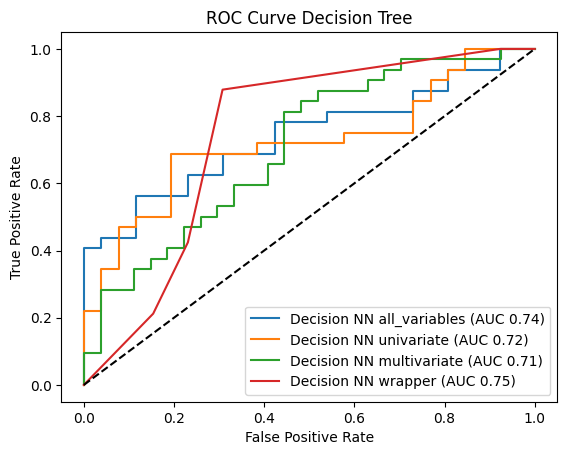

In [99]:
### Neural Network
from sklearn.metrics import confusion_matrix


from scikeras.wrappers import KerasClassifier



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split




aucs_=[]
tprs_=[]
fprs_=[]

model = Sequential()

def createModel(n_of_variables,buildKeras):
    powers_of_two=[16,32,64]

    a_model=Sequential()
    a_model.add(Dense(units=n_of_variables, activation='relu', input_dim=n_of_variables))

    a_model.add(Dense(units=powers_of_two[2], activation='relu'))

    a_model.add(Dense(units=powers_of_two[1], activation='tanh'))

    a_model.add(Dense(units=1, activation='sigmoid'))

    a_model.compile(
                loss='binary_crossentropy',
                metrics=['accuracy']
                )
    
    if buildKeras:
        a_model=KerasClassifier(model=a_model)
    
    return a_model


from sklearn.model_selection import cross_val_score



for a_set in X_lib.keys():


    X_vars=X_lib[a_set]

    n_vars=X_vars.shape[1]

    variables=a_set

    print('variables method: '+variables)


    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)

    
    model=createModel(n_vars,buildKeras=True)

    print(type(model))

    if variables=='wrapper':
        

        ## Weka code using wrapper on MultiLayerPerceptron w greedy stepwise returns variables with index 1,7,9,10

        X_vars=X_vars[:,[1,7,9,10]]

        # # Apply Forward Selection
        # selector = SequentialFeatureSelector(estimator=model, n_features_to_select=9, direction='forward')

        # selector.fit(X_train, y_train)

        # Get the boolean mask of the selected features
        # selected_mask = sffs.get_support()

        # Get the indices of the selected features
        # selected_indices = [i for i, x in enumerate(selected_mask) if x]


        # X_vars=X_vars[:,selected_indices]
        
        n_vars=X_vars.shape[1]

        # print(np.shape(X_vars))
    

    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)

    
    ## use gridsearch 
    
    optimizers = [Adam(learning_rate=.001),Adam(learning_rate=.01)]
    # optimizers = ['SGD', 'RMSprop',  'Adam',  'Nadam']
    epoch_options = [10, 50, 100,200,300]
    batch_sizes=[4,16,32,64]
    verbosity=[0]

    model=createModel(n_vars,buildKeras=True)
    
    grid=dict(optimizer=optimizers,epochs=epoch_options,batch_size=batch_sizes,verbose=verbosity)


    ## Implement Grid Search
    from sklearn.model_selection import GridSearchCV


    gs_cv=GridSearchCV(model,grid,cv=5) #GridSearchCV
    print('Grid Search')
    gs_cv.fit(X_train,y_train)
    # print("tuned hyperparameter K:",gs_cv.best_params_)


    ## use KFold CV as well using the GridSearch Parameters
    from sklearn.model_selection import KFold
    scores=[]
    precisions=[]
    recalls=[]
    f1s=[]

    tps=[]
    tns=[]
    fps=[]
    fns=[]
    aucs=[]

    tprs=[]
    fprs=[]

    kFold=KFold(n_splits=5,shuffle=False)

    # use best gridsearch parameter

    counter=1
    print('Cross Validation')
    for train_index,test_index in kFold.split(X_vars):
        print('Fold #'+str(counter))
        
        model=KerasClassifier(build_fn=createModel(n_vars,buildKeras=False),optimizer=gs_cv.best_params_['optimizer'],
                                    epochs=gs_cv.best_params_['epochs'],
                                    batch_size=gs_cv.best_params_['batch_size'],
                                    )
        print(type(model))

        X_train, X_test, y_train, y_test = X_vars[train_index], X_vars[test_index], y[train_index], y[test_index]
    
        model.fit(X_train, y_train)
        
        scores.append(model.score(X_test, y_test))

        preds=model.predict(X_test)

        C=confusion_matrix(y_test, preds)

        # print(C)


        tp=C[0,0]
        tn=C[1,1]

        fp=C[0,1]
        fn=C[1,0]

        tps.append(tp)
        tns.append(tn)
        
        fps.append(fp)
        fns.append(fn)

        precision=tp/(tp+fp)

        precisions.append(precision)

        recall=tp/(tp+fn)

        recalls.append(recall)



        f1=2*tp/((2*tp)+fp+fn)

        f1s.append(f1)

        y_prob=model.predict_proba(X_test)

        y_prob=y_prob[:,-1]

        auc=roc_auc_score(y_test,y_prob).mean()

        aucs.append(auc) 
        
        fpr, tpr, _ = roc_curve(y_test, y_prob)

        fprs.append(fpr)
        tprs.append(tpr)

        counter+=1


    max_auc_idx=aucs.index(max(aucs))

    fprs_.append(fprs[max_auc_idx])
    tprs_.append(tprs[max_auc_idx])
    aucs_.append(aucs[max_auc_idx])



    # print(precisions)
    # print(recalls)
    # print(f1s)
    # print(tps)

    kfold_mean_precision=np.mean(precisions)
    kfold_mean_recall=np.mean(recalls)
    kfold_mean_f1=np.mean(f1s)

    kfold_min_precision=np.min(precisions)
    kfold_min_recall=np.max(recalls)
    kfold_min_f1=np.min(f1s)

    kfold_max_precision=np.max(precisions)
    kfold_max_recall=np.max(recalls)
    kfold_max_f1=np.max(f1s)

    
    kfold_mean_tps=np.mean(tps)
    kfold_mean_tns=np.mean(tns)
    kfold_mean_fps=np.mean(fps)
    kfold_mean_fns=np.mean(fns)


    kfold_mean_accuracy=np.mean(scores)
    kfold_min_accuracy=np.min(scores)
    kfold_max_accuracy=np.max(scores)

    kfold_min_auc=np.min(aucs)
    kfold_mean_auc=np.mean(aucs)
    kfold_max_auc=np.max(aucs)



    temp_results=pd.DataFrame({'algorithm':['NN'],
                               'variable_method':[variables],
                               'hyper_parameters':[gs_cv.best_params_],
                               'cv_min_accuracy':[kfold_min_accuracy],
                               'cv_max_accuracy':[kfold_min_accuracy],
                               'cv_mean_accuracy':[kfold_min_accuracy],
                               'cv_min_precision':[kfold_min_precision],
                               'cv_max_precision':[kfold_max_precision],
                               'cv_mean_precision':[kfold_mean_precision],
                               'cv_min_f1':[kfold_min_f1],
                               'cv_max_f1':[kfold_max_f1],
                               'cv_mean_f1':[kfold_mean_f1],
                               'cv_mean_tps':[kfold_mean_tps],
                               'cv_mean_tns':[kfold_mean_tns],
                               'cv_mean_fps':[kfold_mean_fps],
                               'cv_mean_fns':[kfold_mean_fns],
                               'cv_mean_auc':[kfold_mean_auc],
                               'cv_min_auc':[kfold_min_auc],
                               'cv_max_auc':[kfold_max_auc]
                               })
    model_results=pd.concat([model_results,temp_results])




## Plot AUC best with each method
plt.figure()



methods=['all_variables','univariate','multivariate','wrapper']

for idx in range(0,len(X_lib.keys())):
    cur_method=methods[idx]
    plt.plot(fprs_[idx], tprs_[idx], label=f"Decision NN "+cur_method+f" (AUC {aucs_[idx]:.2f})")
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Decision Tree")
plt.legend(loc="best")
# plt.show()


plt.savefig('AUC_comparison_NN.png')

    



In [26]:
### Rule Induction

# import weka.core.jvm as jvm

# import os
# os.environ["JAVA_HOME"] ='C:/Users/melli/Downloads/openrefine-win-with-java-3.8.2/openrefine-3.8.2/server/target/jre/bin/client'

# print(jvm.started)

# if not jvm.started:
#     jvm.start()

# from weka.classifiers import Classifier
# from weka.core.converters import Loader




# # Load the dataset (ARFF or CSV format)
# loader = Loader(classname="weka.core.converters.ArffLoader")  # Use CSVLoader if CSV
# data = loader.load_file("dataset_scaled.arff")
# data.class_is_last()  # Specify the class attribute

# # Build the PART classifier
# part = Classifier(classname="weka.classifiers.rules.PART")
# part.build_classifier(data)



# jvm.stop()




In [100]:
model_results.to_csv('model_results.csv',index=False)